In [19]:
import pandas as pd
import numpy as np
import glob
import os

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [2]:
path_files = r'./tirages/*.csv'

all_files = glob.glob(path_files)





#filename = all_files[0]

df_list = []

for filename in all_files:
    df = pd.read_csv(filename, sep=';', parse_dates=['date_de_tirage'], dayfirst=True)
    
    df = df[["date_de_tirage", "boule_1", "boule_2", "boule_3", "boule_4", "boule_5", "numero_chance"]]
    
    df.rename(columns={
        'date_de_tirage': 'date_tirage',
        'boule_1': 'num0',
        'boule_2':'num1', 
        "boule_3": "num2", 
        "boule_4": "num3", 
        "boule_5": "num4", 
        "numero_chance": "chance"},inplace=True)
    print(df.shape)
    df_list.append(df)
    #break;

df = pd.concat(df_list)

# placer le dernier tirage en dernière position
df.sort_values('date_tirage', ascending = True, inplace=True)
df.shape

df = df[["date_tirage", "num0"]]

tdi = pd.DatetimeIndex(df.date_tirage)
df.set_index(tdi, inplace=True)
df.drop(columns='date_tirage', inplace=True)
df.index.name = 'datetimeindex'



(4858, 7)
(310, 7)
(107, 7)
(455, 7)
(1317, 7)


In [3]:
df.head()

,num0
datetimeindex,
1976-05-19,31
1976-06-03,10
1976-06-10,44
1976-06-16,2
1976-06-23,30


In [25]:
df.tail()

,num0
datetimeindex,
2022-09-19,5
2022-09-21,3
2022-09-24,25
2022-09-26,29
2022-09-28,12


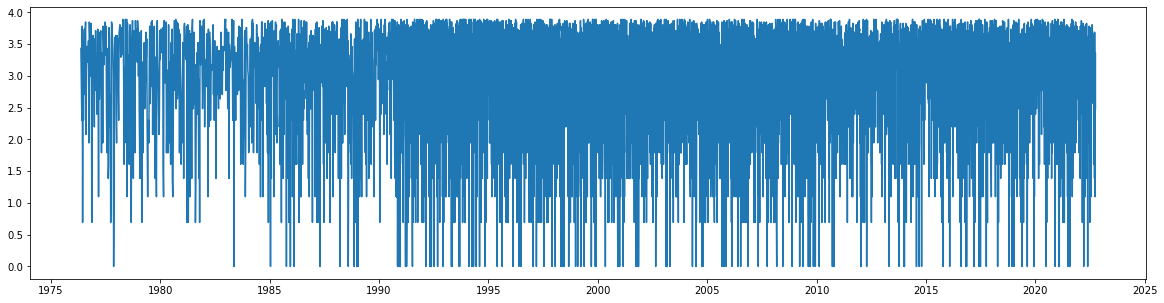

In [5]:
plt.figure(figsize=(20,5))
df_log = np.log(df)
plt.plot(df_log);

générer une série avec une tendance linéaire et légèrement bruitée.

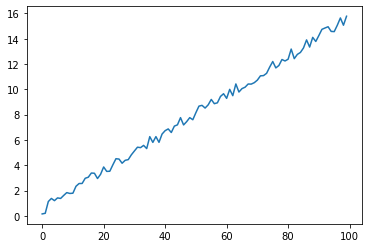

In [6]:
epsilon = np.random.rand(100) #Bruit Blanc
t  = np.linspace(0,10,100) # Temps
alpha = 1.5 #coefficient de tendance
total = pd.DataFrame(alpha * t + epsilon)
plt.plot(total);

stationnariser les séries<br>
la tendance a été supprimée et donc la série est stationnaire

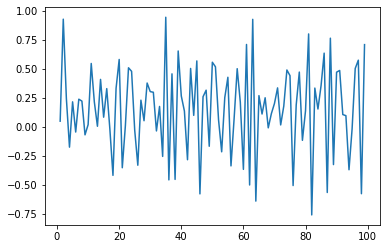

In [7]:
total_diff = total.diff().dropna() #différenciation
plt.plot(total_diff);

Fonction d'autocorrélation de la série de données.

(-0.05, 0.05)

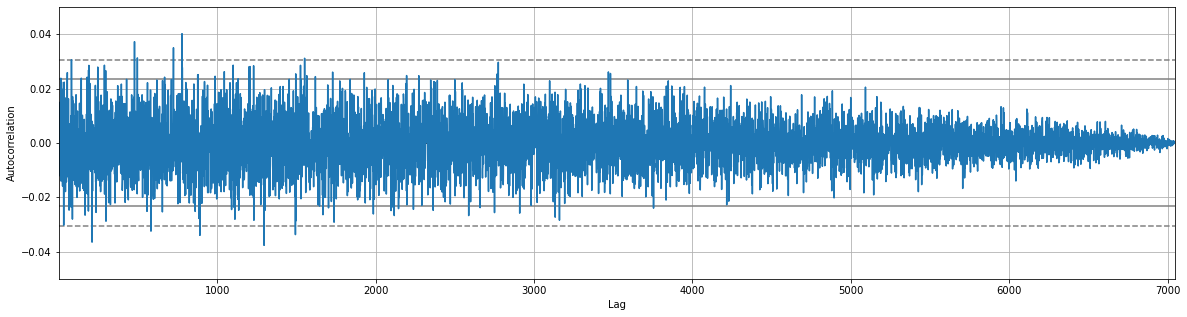

In [16]:
plt.figure(figsize=(20,5))
ax = pd.plotting.autocorrelation_plot(df_log);
ax.set_ylim([-0.05, 0.05])

In [17]:
df_log_1 = df_log.diff().dropna() #Differenciation simple 

df_log_2 = df_log_1.diff(periods = 12).dropna() #Différenciation d'ordre 12

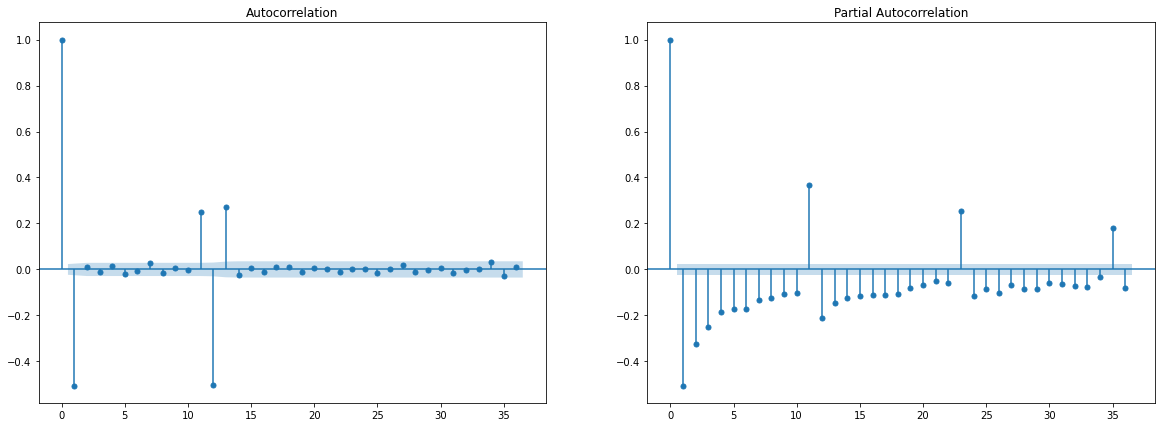

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(df_log_2, lags = 36, ax=ax1)
plot_pacf(df_log_2, lags = 36, ax=ax2)
plt.show()

On remarque qu'à la fois l'autocorrélation simple et partielle tendent vers 0<br>
On peut donc supposer un processus  ARMA(p,q)ARMA⁡(p,q) 

In [21]:
model=sm.tsa.SARIMAX(df_log,order=(1,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                               num0   No. Observations:                 7047
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -9097.810
Date:                            Tue, 11 Oct 2022   AIC                          18203.620
Time:                                    22:21:24   BIC                          18231.054
Sample:                                         0   HQIC                         18213.071
                                           - 7047                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050      0.012      0.412      0.681      -0.019       0.029
ma.L1         -0.9989      0.001   

modèle SARIMAX correspondant au modèle  SARIMA(0,1,1)(0,1,1)12SARIMA⁡(0,1,1)(0,1,1)12 .

In [22]:
model = sm.tsa.SARIMAX(df_log,order=(0,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                               num0   No. Observations:                 7047
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -9096.920
Date:                            Tue, 11 Oct 2022   AIC                          18199.841
Time:                                    22:25:13   BIC                          18220.416
Sample:                                         0   HQIC                         18206.929
                                           - 7047                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.004   -229.558      0.000      -1.008      -0.991
ma.S.L12      -0.9998      0.032   

Prédire les valeurs de la série sur les 12 mois suivant la dernière valeur 

(19174.0, 19358.0, 0.0, 50.0)

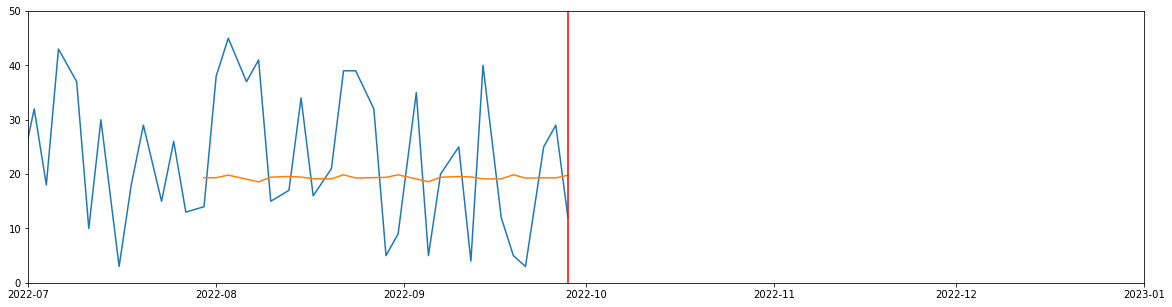

In [69]:
import datetime
pred = np.exp(sarima.predict(7020, 7046))#Prédiction et passage à l'exponentielle

df_pred = pd.concat([df, pred])#Concaténation des prédictions

plt.figure(figsize=(20,5))

plt.plot(df_pred) #Visualisation
plt.axvline(x= datetime.date(2022,9,28), color='red'); # Ajout de la ligne verticale
plt.axis([datetime.date(2022,7,1), datetime.date(2023,1,1), 0, 50])